In [1]:
from IPython.display import HTML

def color_block(color, info):
    html_code = f"<div style='background-color: {color}; padding: 6px; border: 10x solid black;'> {info} </div>"
    display(HTML(html_code))

In [ ]:
color_block('grey', "Library deloying")

## Libaries

In [4]:
%pip install nnfs

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data, vertical_data
import matplotlib.pyplot as plt

In [2]:
nnfs.init()

## Defining class called Layer_Dense.
- Objects are layers, with random weights and zero biases. 
    - The standard normal distribution is a normal distribution where the **mean is 0** and the **standard deviation is 1.**
    - For random samples from the normal distribution with mean ``mu`` and  
      standard deviation ``sigma``, use:: **sigma \* np.random.randn(...) + mu**
  


In [6]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons) # this order of parameters help skip the transpose of weight matrix in dot product with inputs.
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

In [7]:
#testing class Layer_Dense, Passed
dense_test = Layer_Dense(2, 5)

illus_inputs = np.array([[1,2], [3,4], [5,6]])
dense_test.forward(illus_inputs)

print(f"verify dims: {illus_inputs.shape} x {dense_test.weights.shape} = {dense_test.output.shape}")
print("Weights\n", dense_test.weights, "Biases\n", dense_test.biases)
print("Layer output\n", dense_test.output)

verify dims: (3, 2) x (2, 5) = (3, 5)
Weights
 [[ 0.01764052  0.00400157  0.00978738  0.02240893  0.01867558]
 [-0.00977278  0.00950088 -0.00151357 -0.00103219  0.00410599]] Biases
 [[0. 0. 0. 0. 0.]]
Layer output
 [[-0.00190503  0.02300334  0.00676024  0.02034455  0.02688755]
 [ 0.01383046  0.05000826  0.02330785  0.06309804  0.07245068]
 [ 0.02956595  0.07701316  0.03985547  0.10585152  0.11801381]]


## Defining class called Activation_ReLU
- Rectified Linear Unit Activation function inside hidden layer is a power to learn non-linearity in training data.
- More granular and informative for optimizers. **AREA OF EFFECT**

In [10]:
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

In [ ]:
#testing calss Activation_ReLU
Relu_test = Activation_ReLU()
Relu_test.forward(dense_test.output)
print(Relu_test.output)     

[[0.         0.02300334 0.00676024 0.02034455 0.02688755]
 [0.01383046 0.05000826 0.02330785 0.06309804 0.07245068]
 [0.02956595 0.07701316 0.03985547 0.10585152 0.11801381]]


## Defining class called Activation_Softmax
- One of activation function for classification task.
- helps in normalization(0,1) and probability distribution. Soft Max = Soothning of normaml max function.
- np.exp(1000) **overflow encountered in exp**. Taking Advantage of function behaviour at x = 0 and x = -∞. Subtracting max(list) from all list elements. Output will be same.

In [13]:
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs,
                                           axis=1,
                                           keepdims=True))
        probabilities = exp_values / np.sum(exp_values,
                                           axis=1,
                                           keepdims=True)
        self.output = probabilities

In [15]:
#test class Activation_Softmax
softmax_test =  Activation_Softmax()
softmax_test.forward(Relu_test.output)
print(softmax_test.output)
verify_eachoutput_sum = np.sum(softmax_test.output, axis=1)
print(f"sum across each ouput must equal to 1: {verify_eachoutput_sum}")

[[0.19693343 0.20151605 0.19826925 0.20098096 0.20230031]
 [0.1939023  0.20104569 0.19574873 0.20369464 0.20560867]
 [0.1911797  0.20046926 0.19315699 0.20633465 0.20885946]]
sum across each ouput must equal to 1: [1.        1.        1.0000001]


In [17]:
class Loss:
    
    def calculate(self, output, y):
        samples_losses = self.forward(output, y)
        data_loss = np.mean(samples_losses)
        return data_loss

### Self clarification
    1. how output of softmax function can be zero? 
        No, it can't coz exponent power anything never be zero. In computer languages it hits -inf.
    2. then why we clip values in categoricalcrossentropy?
        when softmax output exceeds 323 decimal point, output -inf. 

In [30]:
ii = 1
varr = 0.1
varrr = np.log(0)

while np.log(varr) != varrr:
    varr /= 10
    ii += 1

print(f"np.log() ouputs -inf when input value <= 1e-{ii}")

np.log() ouputs -inf when input value <= 1e-324


/tmp/ipykernel_4169/3398997726.py:3: RuntimeWarning: divide by zero encountered in log
  varrr = np.log(0)
/tmp/ipykernel_4169/3398997726.py:5: RuntimeWarning: divide by zero encountered in log
  while np.log(varr) != varrr:


In [19]:
class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            samples = len(y_pred)
            correct_confidences = y_pred_clipped[range(samples),
                                                  y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true,
                                         axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

In [21]:
illus_ccl = Loss_CategoricalCrossentropy()

illus_target_ouput = np.array([0, 2, 4])
batch_loss = illus_ccl.calculate(softmax_test.output, illus_target_ouput)

print(f"Averge loss over sample batch = {batch_loss}")

Averge loss over sample batch = 1.607302188873291


## Calculate Accuracy using Argmax function
- np.argmax() take input as 2d np array, outputs 1d array of index of maximum value of each array in inputs.

In [31]:
def accuracy_calculation(activation_ouput, class_target):
    predictions = np.argmax(activation_ouput, axis=1)
    if len(class_target.shape) == 2:
        class_target = np.argmax(class_target, axis=1)
    return np.mean(predictions == class_target)

In [32]:
acc = accuracy_calculation(softmax_test.output, illus_target_ouput)
print(acc)

0.3333333333333333


## Rough Data set Preparation
- from nnfs library.
- spiral, vertical.. data

In [201]:
x_spiral, y_spiral = spiral_data(samples=100, classes=3)

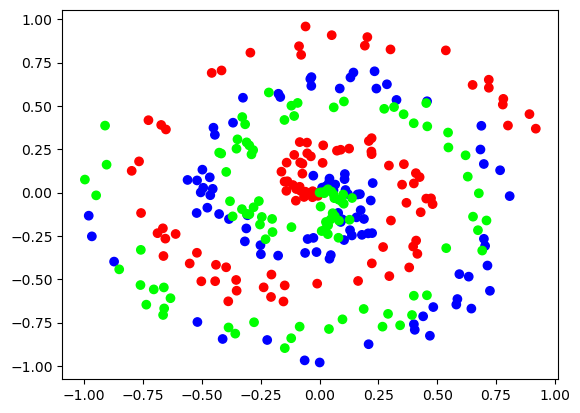

In [202]:
plt.scatter(x_spiral[:300, 0], x_spiral[:300, 1], c=y_spiral[:300], cmap='brg')
plt.show()

In [204]:
x_vertical, y_vertical = vertical_data(samples=100, classes=3)

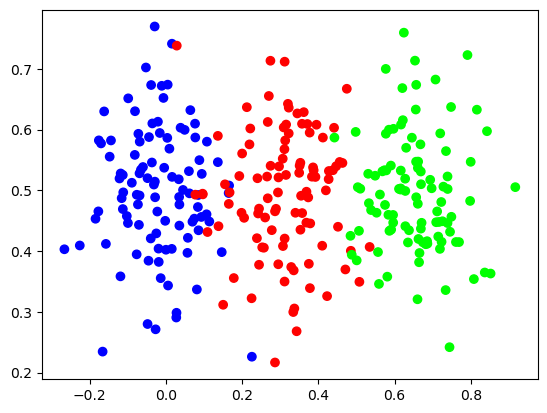

In [205]:
plt.scatter(x_vertical[:, 0], x_vertical[:, 1], c=y_spiral[:], cmap='brg')
plt.show()

In [247]:
def random_weights(data_x, data_y):

    # network architecture
    dense1 = Layer_Dense(2, 3)
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense(3, 3)
    activation2 = Activation_Softmax()
    
    loss_function = Loss_CategoricalCrossentropy()
    
    lowest_loss = 9999999
    
    best_dense1_weights = dense1.weights.copy()
    best_dense1_biases = dense1.biases.copy()
    best_dense2_weights = dense2.weights.copy()
    best_dense2_biases = dense2.biases.copy()
    
    loss_list = list()
    accuracy_list = list()
    
    for iteration in range(10000):
        
        dense1.weights = 0.05 * np.random.randn(2, 3)
        dense1.biases = 0.05 * np.random.randn(1, 3)
        dense2.weights = 0.05 * np.random.randn(3, 3)
        dense2.biases = 0.05 * np.random.randn(1, 3)

        # network forward propagation
        dense1.forward(data_x)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
    
        loss = loss_function.calculate(activation2.output, data_y)
        accuracy = accuracy_calculation(activation2.output, data_y)
    
        loss_list.append(loss)
        accuracy_list.append(accuracy)
    
        if loss < lowest_loss:
            print('New set of weights found and iteration:', iteration,
                 'loss:', loss,
                 'acc:', accuracy)
            lowest_loss = loss
            best_dense1_weights = dense1.weights.copy()
            best_dense1_biases = dense1.biases.copy()
            best_dense2_weights = dense2.weights.copy()
            best_dense2_biases = dense2.biases.copy()
            
    print(f'''              maximum of loss: {max(loss_list)},
              minimum of loss: {min(loss_list)},
              maximum of accuracy: {max(accuracy_list)},
              minimum of accuracy: {min(accuracy_list)}''')
    
    plt.plot(loss_list)
    plt.show()
    plt.plot(accuracy_list)
    plt.show()

New set of weights found and iteration: 0 loss: 1.098702 acc: 0.3333333333333333
New set of weights found and iteration: 2 loss: 1.0985894 acc: 0.33666666666666667
New set of weights found and iteration: 14 loss: 1.098456 acc: 0.33
New set of weights found and iteration: 35 loss: 1.0984344 acc: 0.3333333333333333
New set of weights found and iteration: 64 loss: 1.0983124 acc: 0.37
New set of weights found and iteration: 91 loss: 1.0980821 acc: 0.33666666666666667
New set of weights found and iteration: 2758 loss: 1.0980122 acc: 0.3333333333333333
              maximum of loss: 1.1064006090164185,
              minimum of loss: 1.0980122089385986,
              maximum of accuracy: 0.41333333333333333,
              minimum of accuracy: 0.25666666666666665


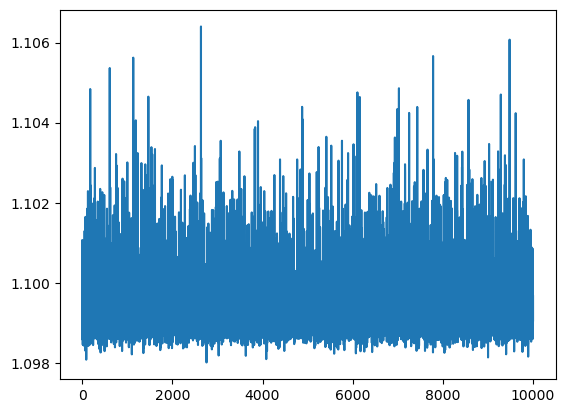

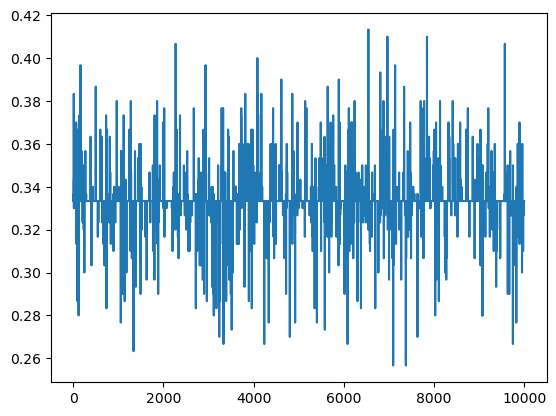

In [242]:
random_weights(x_spiral, y_spiral)

New set of weights found and iteration: 0 loss: 1.0984757 acc: 0.3333333333333333
New set of weights found and iteration: 11 loss: 1.0980017 acc: 0.3333333333333333
New set of weights found and iteration: 46 loss: 1.097679 acc: 0.3333333333333333
New set of weights found and iteration: 50 loss: 1.0968045 acc: 0.3333333333333333
New set of weights found and iteration: 225 loss: 1.0965452 acc: 0.3333333333333333
New set of weights found and iteration: 1559 loss: 1.0954608 acc: 0.3333333333333333
              maximum of loss: 1.1062794923782349,
              minimum of loss: 1.0954607725143433,
              maximum of accuracy: 0.6666666666666666,
              minimum of accuracy: 0.0


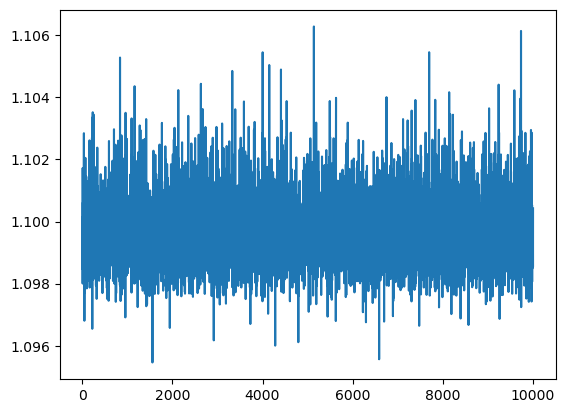

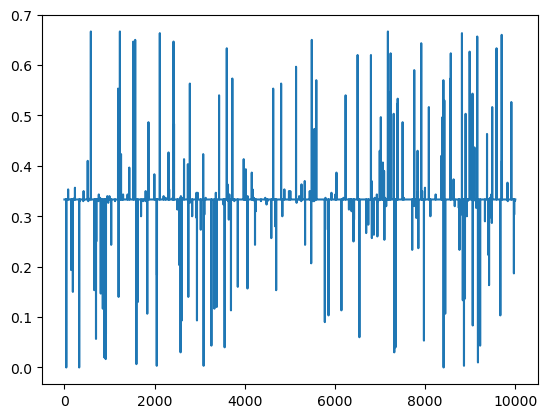

In [243]:
random_weights(x_vertical, y_vertical)

In [246]:
def random_roll_gradient_weights(data_x, data_y):
    
    dense1 = Layer_Dense(2, 3)
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense(3, 3)
    activation2 = Activation_Softmax()
    
    loss_function = Loss_CategoricalCrossentropy()
    
    lowest_loss = 9999999
    
    best_dense1_weights = dense1.weights.copy()
    best_dense1_biases = dense1.biases.copy()
    best_dense2_weights = dense2.weights.copy()
    best_dense2_biases = dense2.biases.copy()
    
    loss_list = list()
    accuracy_list = list()
    
    for iteration in range(10000):
        
        dense1.weights += 0.05 * np.random.randn(2, 3)
        dense1.biases += 0.05 * np.random.randn(1, 3)
        dense2.weights += 0.05 * np.random.randn(3, 3)
        dense2.biases += 0.05 * np.random.randn(1, 3)
    
        dense1.forward(data_x)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
    
        loss = loss_function.calculate(activation2.output, data_y)
        accuracy = accuracy_calculation(activation2.output, data_y)
    
        loss_list.append(loss)
        accuracy_list.append(accuracy)
    
        if loss < lowest_loss:
            print('New set of weights found and iteration:', iteration,
                 'loss:', loss,
                 'acc:', accuracy)
            lowest_loss = loss
            best_dense1_weights = dense1.weights.copy()
            best_dense1_biases = dense1.biases.copy()
            best_dense2_weights = dense2.weights.copy()
            best_dense2_biases = dense2.biases.copy()
        else:
            dense1.weights = best_dense1_weights.copy()
            dense1.biases = best_dense1_biases.copy()
            dense2.weights = best_dense2_weights.copy()
            dense2.biases = best_dense2_biases.copy()
            
            
    print(f'''              maximum of loss: {max(loss_list)},
              minimum of loss: {min(loss_list)},
              maximum of accuracy: {max(accuracy_list)},
              minimum of accuracy: {min(accuracy_list)}''')
    
    plt.plot(loss_list)
    plt.show()
    plt.plot(accuracy_list)
    plt.show()

New set of weights found and iteration: 0 loss: 1.1018484 acc: 0.3333333333333333
New set of weights found and iteration: 2 loss: 1.1004946 acc: 0.3333333333333333
New set of weights found and iteration: 4 loss: 1.1000838 acc: 0.3333333333333333
New set of weights found and iteration: 5 loss: 1.099188 acc: 0.3333333333333333
New set of weights found and iteration: 10 loss: 1.098976 acc: 0.3333333333333333
New set of weights found and iteration: 11 loss: 1.0984555 acc: 0.3233333333333333
New set of weights found and iteration: 12 loss: 1.0974153 acc: 0.3333333333333333
New set of weights found and iteration: 16 loss: 1.0968382 acc: 0.3433333333333333
New set of weights found and iteration: 18 loss: 1.0960389 acc: 0.3933333333333333
New set of weights found and iteration: 21 loss: 1.0950729 acc: 0.4033333333333333
New set of weights found and iteration: 25 loss: 1.0927337 acc: 0.38
New set of weights found and iteration: 26 loss: 1.0924581 acc: 0.38
New set of weights found and iteration

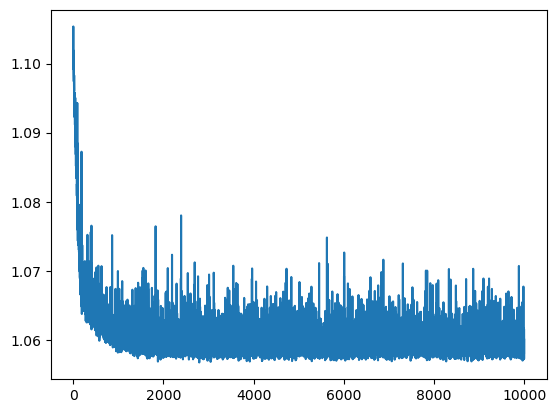

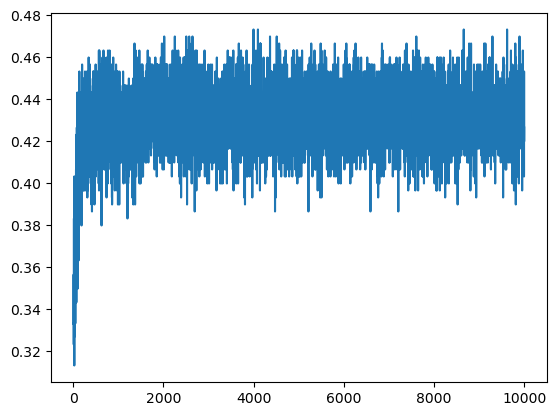

In [248]:
random_roll_gradient_weights(x_spiral, y_spiral)

New set of weights found and iteration: 0 loss: 1.0979847 acc: 0.3333333333333333
New set of weights found and iteration: 10 loss: 1.0970163 acc: 0.3333333333333333
New set of weights found and iteration: 17 loss: 1.0959731 acc: 0.3333333333333333
New set of weights found and iteration: 19 loss: 1.0957164 acc: 0.3333333333333333
New set of weights found and iteration: 20 loss: 1.0954392 acc: 0.3333333333333333
New set of weights found and iteration: 21 loss: 1.0949676 acc: 0.4066666666666667
New set of weights found and iteration: 24 loss: 1.0942508 acc: 0.3566666666666667
New set of weights found and iteration: 26 loss: 1.0895182 acc: 0.3333333333333333
New set of weights found and iteration: 28 loss: 1.0890727 acc: 0.6633333333333333
New set of weights found and iteration: 32 loss: 1.0846435 acc: 0.37
New set of weights found and iteration: 33 loss: 1.0830992 acc: 0.66
New set of weights found and iteration: 36 loss: 1.0779724 acc: 0.6633333333333333
New set of weights found and iter

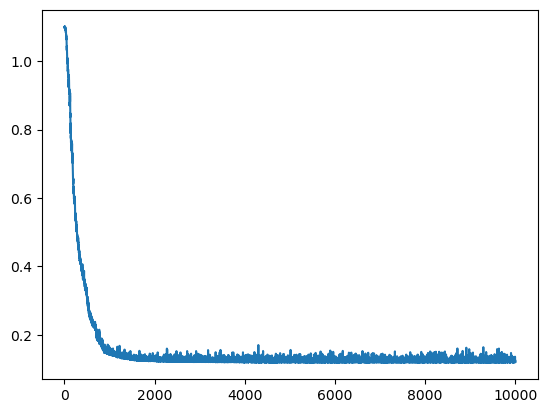

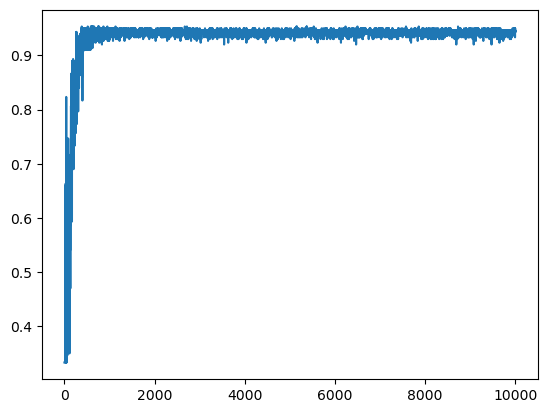

In [249]:
random_roll_gradient_weights(x_vertical, y_vertical)

(x1, y1), (x2, y2): ((0, 0), (0.0001, 3.0000000000000004e-08)) Approx derivate at x1: 0.00030000000000000003
(x1, y1), (x2, y2): ((1, 3), (1.0001, 3.0006000299999998)) Approx derivate at x1: 6.000299999998177
(x1, y1), (x2, y2): ((2, 12), (2.0001, 12.001200030000003)) Approx derivate at x1: 12.000300000007059
(x1, y1), (x2, y2): ((3, 27), (3.0001, 27.001800030000005)) Approx derivate at x1: 18.00030000001594
(x1, y1), (x2, y2): ((4, 48), (4.0001, 48.00240003)) Approx derivate at x1: 24.000300000024822


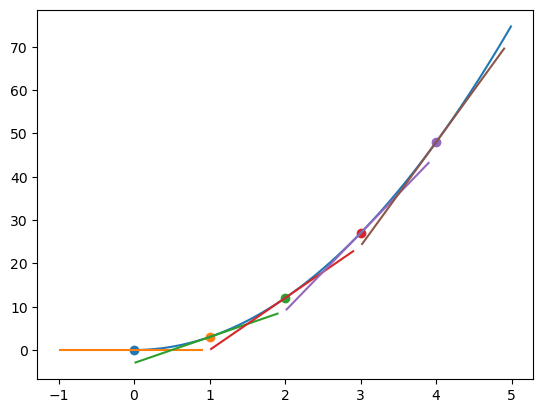

In [35]:
def f(x):
    return 3*x**2

x = np.array(np.arange(0, 5, 0.01))
y = f(x)

plt.plot(x, y)

def approximate_tangent_line(x):
    return approximate_derivative*x + b

for i in range(5):
    delta = 0.0001
    x1 = i
    x2 = x1 + delta

    y1 = f(x1)
    y2 = f(x2)

    approximate_derivative = (y2 - y1)/(x2 - x1)
    b = y2 - approximate_derivative*x2
    xl = [x1-0.98, x1, x1+0.9]
    yl  =  [approximate_tangent_line(xx) for xx in xl]

    plt.scatter(x1, y1)
    plt.plot(xl, yl)
    
    print(f"(x1, y1), (x2, y2): {(x1, y1), (x2, y2)}", f"Approx derivate at x1: {approximate_derivative}")

plt.show()
    

xg_axis: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20],
yg_axis: [0, 4, 16, 36, 64, 100, 144, 196, 256, 324, 400, 484, 576, 676, 784, 900, 1024, 1156, 1296, 1444, 1600]


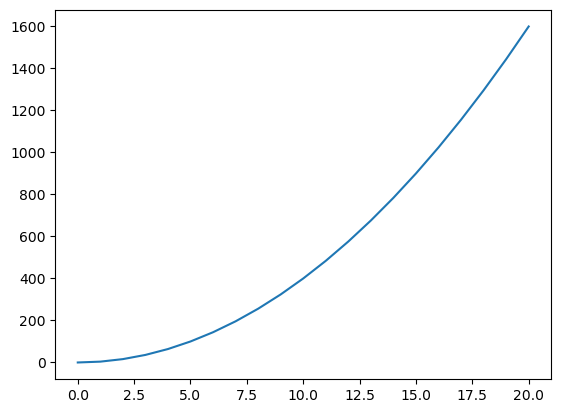

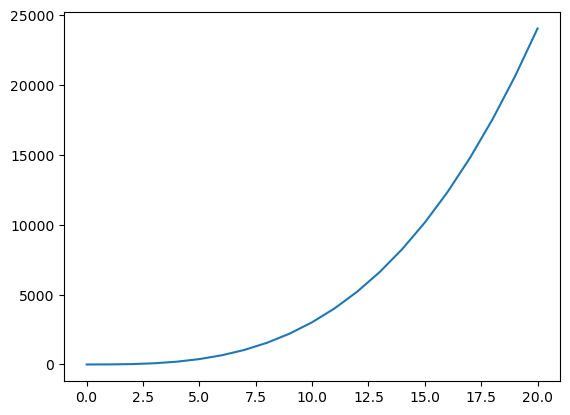

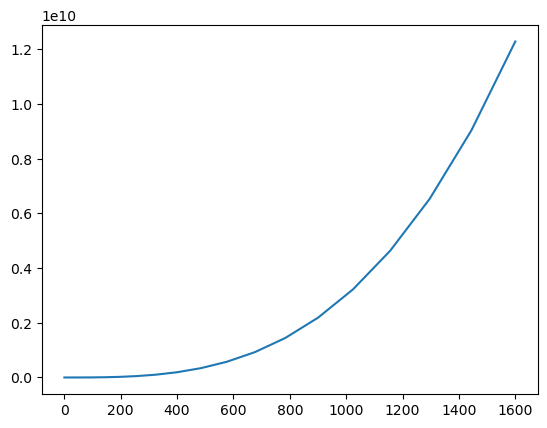

In [2]:
# partial derivative of chain of functions
def f1(x):
    return 3*x**3 + 2*x

def g1(x):
    return 4*x**2

xg_axis = np.arange(0, 21)
yg_axis = [g1(i) for i in xg_axis]
print(f"xg_axis: {xg_axis},\nyg_axis: {yg_axis}")
plt.plot(xg_axis, yg_axis)
plt.show()

plt.plot(xg_axis, [f1(i) for i in xg_axis])
plt.show()

plt.plot(yg_axis, [f1(i) for i in yg_axis])
plt.show()